# Balancing a Pole on a Cart
## 23S2 SC3000 Assignment 1
---
## Team Name: RL Enjoyers (Group A35)
---
## Team Members
- Clement Tan Kang Hao
- Darren Ng Joon Kai
- Denzyl David Peh
---
## Team Contribution

#### Training the RL Agent
- Discretizatisation of states - Clement, Darren
- returnIndexState() - Denzyl
- selectAction() - Clement
- simulateEpisodes() - Darren, Denzyl, Clement

#### Task 1: Development of RL Agent
- Sampling of random state from the CartPole Environment - Darren

#### Task 2: Demonstrate the effectiveness of the RL agent
- Running 100 episodes of the RL agent - Denzyl
- Plotting cumulative reward against episodes using Matplotlib - Darren
- Calculation of average reward over the 100 episodes - Clement

#### Task 3: Render one episode played by the developed RL agent on Jupyter
- Rendering video of an episode of our trained RL agent - Darren

#### Task 4: Format the Jupyter notebook
- Writing of step-by-step instructions and explanations - Clement, Darren, Denzyl
---
## References
- Detailed Explanation and Python Implementation of Q-Learning Algorithm in OpenAI Gym (Cart-Pole) - https://www.youtube.com/watch?v=KMjQmG5Uzis
- Q Learning In Reinforcement Learning | Q Learning Example | Machine Learning Tutorial | Simplilearn - https://www.youtube.com/watch?v=tMnc-hhO2jE
- Detailed Explanation and Python Implementation of the Q-Learning Algorithm with Tests in Cart Pole OpenAI Gym Environment – Reinforcement Learning Tutorial - https://aleksandarhaber.com/q-learning-in-python-with-tests-in-cart-pole-openai-gym-environment-reinforcement-learning-tutorial/
- Sample codes from Problem Description
---

# Installing dependencies:

In [ ]:
!pip install gym==0.25.2
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install moviepy > /dev/null 2>&1
!pip install pygame > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importing dependencies and define helper functions

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

# Loading CartPole environment

In [ ]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [ ]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [ ]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [ ]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [ 0.04850512  0.03725411  0.01043059 -0.00046955]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [ ]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.04925021 -0.15801586  0.0104212   0.29548603]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [ ]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 10.0


# Training the RL agent

We first begin by initializing the reinforcement learning environment using the OpenAI Gym library with the **"CartPole-v1"** environment. It also sets upsome initial values and parameters for the Q-learning algorithm.

The ***'alpha'***, ***'gamma'***, and ***'epsilon'*** parameters are hyperparameters that control the learning rate, discount factor, and explorataion rate, respectively.

The ***'numberOfBinsPosition'***, ***'numberOfBinsVelocity'***, ***'numberOfBinsAngle'***, and ***'numberOfBinsAngleVelocity'*** variables determine the number of bins to discretize the observation space for the Q-matrix.

The ***'actionNumber'*** variable is the number of possible actions in the environment.

The ***'Qmatrix'*** variable is initialized as a numpy array with random values between 0 and 1. It has dimensions corresponding to the number of bins in each dimension of the observation space and the number of possible actions.

The ***'upperBound'*** and ***'lowerBounds'*** variables are arrays that define the maximum and minimum values for each dimension of the observation space. They are modified to adjust the bounds for the velocity and angular velocity of the cart and the pole.



In [ ]:
env = gym.make("CartPole-v1")

# initialise values
alpha=0.1
gamma=1
epsilon=0.2
sumRewardsEpisodes=[]
numberOfBinsPosition=30
numberOfBinsVelocity=30
numberOfBinsAngle=30
numberOfBinsAngleVelocity=30
numberOfBins=[numberOfBinsPosition,numberOfBinsVelocity,numberOfBinsAngle,numberOfBinsAngleVelocity]
actionNumber=env.action_space.n

# initialise Qmatrix
Qmatrix=np.random.uniform(low=0, high=1, size=(numberOfBins[0],numberOfBins[1],numberOfBins[2],numberOfBins[3],actionNumber))

upperBounds=env.observation_space.high
lowerBounds=env.observation_space.low
cartVelocityMin=-3
cartVelocityMax=3
poleAngleVelocityMin=-10
poleAngleVelocityMax=10
upperBounds[1]=cartVelocityMax
upperBounds[3]=poleAngleVelocityMax
lowerBounds[1]=cartVelocityMin
lowerBounds[3]=poleAngleVelocityMin


The function ***'returnIndexState(state)'*** takes a state array as input and returns the indices of the bins that are closest to the values of the state variables.

The function first extracts the values of the state variables into separate variables. It then creates the bins for each of the state variables using the ***'np.linspace'*** function.

The function then uses the ***'np.digitize'*** function to return the index of the bin that is closest to each of the state variables. The *'-1'* is used to adjust the indices returned by ***'np.digitize'*** so that they start from zero instead of one. Finally, the function returns the indices as a tuple.

In [ ]:
def returnIndexState(state):

    # extracting values from the state array into their rightful variables
    position = state[0]
    velocity = state[1]
    angle = state[2]
    angularVelocity = state[3]

    # creates the bins for each of the states using np.linspace function
    cartPositionBin = np.linspace(lowerBounds[0], upperBounds[0],numberOfBins[0])
    cartVelocityBin = np.linspace(lowerBounds[1], upperBounds[1],numberOfBins[1])
    poleAngleBin = np.linspace(lowerBounds[2], upperBounds[2],numberOfBins[2])
    poleAngleVelocityBin = np.linspace(lowerBounds[3], upperBounds[3],numberOfBins[3])

    # returns the index of the closest bin to the state, -1 to adjust the indices returned by np.digitize to start from zero instead of one
    indexPosition=np.maximum(np.digitize(position, cartPositionBin)-1,0)
    indexVelocity=np.maximum(np.digitize(velocity, cartVelocityBin)-1,0)
    indexAngle=np.maximum(np.digitize(angle, poleAngleBin)-1,0)
    indexAngularVelocity=np.maximum(np.digitize(angularVelocity, poleAngleVelocityBin)-1,0)

    return tuple([indexPosition, indexVelocity, indexAngle, indexAngularVelocity])

The ***'selectAction'*** function implements an epsilon-greedy algorithm for action selection in reinforcement learning. The function takes as input the current state, the episode index, and a boolean flag indicating whether the agent is still in training mode.

During the first 500 episodes, the function selects actions randomly to promote exploration. After 7000 episodes, the value of the exploration parameter epsilon starts to decrease gradually, which means that the function starts to select actions more greedily.

The function selects an action based on a random number generated between 0 and 1. If the random number is less than epsilon, the function selects an action randomly. Otherwise, the function selects the action with the highest Q-value for the current state, which represents a greedy action.

In [ ]:
def selectAction(state, index, isTraining):
    global epsilon
    # we set the first 500 episodes to choose random actions for exploration
    if index<500 and isTraining:
        return np.random.choice(actionNumber)

    # return a random real number in the half-open interval [0.0,1.0]
    # this number is used for epsilon greedy approach
    randomNumber = np.random.random()

    # epsilon is a threshold for exploration. As epsilon decreases, the threshold for exploration decreases meaning that selection will be greedy instead of random
    # after 7000 episodes, we slowly start to decrease epsilon parameter
    if index>7000:
        epsilon=0.999*epsilon

    # if this condition is satisfied, we are exploring, meaning selecting random actions
    # with a smaller epsilon this statement when have a higher probability of being false, therefore else statement is executed
    if randomNumber < epsilon:
        return np.random.choice(actionNumber)

    # in this else statement, we are selecting greedy actions
    else:
        # we return the index where Qmatrix[state] has the max value
        # that is, since the index denotes an action, we select greedy actions
        return np.random.choice(np.where(Qmatrix[returnIndexState(state)]==np.max(Qmatrix[returnIndexState(state)]))[0]) 

The ***'simulateEpisodes'*** function trains the agent by running multiple episodes. Within each episode, the function selects actions based on the current state using the ***'selectAction'*** function, which uses an epsilon-greedy approach for exploration. 

The function then steps through the environment and updates the Q-matrix using the Q-learning algorithm. 

The rewards earned during each episode are stored in a list ***'rewardsEpisode'***. The function also prints the current episode number and the sum of rewards earned in that episode.

In [ ]:
def simulateEpisodes(numberEpisodes, isTraining):
    # this function is for training the agent
    for indexEpisode in range(numberEpisodes):

        # list that stores rewards per episode 
        rewardsEpisode=[]

        # reset the environment at the beginning of every episode
        stateS = env.reset()
        stateS = list(stateS)

        print("Simulating episode {}".format(indexEpisode))

        # stepping from one state to another
        # loop until a terminal state is reached
        terminalState = False
        while not terminalState:
            # return a discretized index of the state
            stateSIndex=returnIndexState(stateS)

            # select an action on the basis of the current state, denoted by stateS
            actionA=selectAction(stateS, indexEpisode, isTraining)

            # step and return the state, reward and boolean denoting if the state is a terminal state or not, '_' will not be in use therefore is not named
            stateSprime, reward, terminalState, _ = env.step(actionA)

            rewardsEpisode.append(reward)

            stateSprime=list(stateSprime)

            stateSprimeIndex=returnIndexState(stateSprime)

            # return the max value, we do not need actionAprime
            QmaxPrime=np.max(Qmatrix[stateSprimeIndex])

            if not terminalState:
                # stateS+(actionA,) - we use this notation to append the tuples
                # for example, for stateS(0,0,0,1) and actionA=(1,0)
                # we have stateS+(actionA,) = (0,0,0,1,0)
                error = reward+gamma*QmaxPrime-Qmatrix[stateSIndex+(actionA,)]
                Qmatrix[stateSIndex+(actionA,)] = Qmatrix[stateSIndex+(actionA,)]+alpha*error

            else:
                # in the terminal state, we have Qmatrix[stateSprime, actionAprime] = 0
                error = reward+gamma*QmaxPrime-Qmatrix[stateSIndex+(actionA,)]
                Qmatrix[stateSIndex+(actionA,)] = Qmatrix[stateSIndex+(actionA,)]+alpha*error

            stateS=stateSprime

        print("Sum of rewards {}".format(np.sum(rewardsEpisode)))
        sumRewardsEpisodes.append(np.sum(rewardsEpisode))

In [ ]:
Qmatrix=np.random.uniform(low=0, high=1, size=(numberOfBins[0],numberOfBins[1],numberOfBins[2],numberOfBins[3],actionNumber))

# run 30000 episodes for training, prioritise initial exploration
simulateEpisodes(30000, True)

Streaming output truncated to the last 5000 lines.
Simulating episode 27500
Sum of rewards 382.0
Simulating episode 27501
Sum of rewards 291.0
Simulating episode 27502
Sum of rewards 500.0
Simulating episode 27503
Sum of rewards 202.0
Simulating episode 27504
Sum of rewards 313.0
Simulating episode 27505
Sum of rewards 362.0
Simulating episode 27506
Sum of rewards 330.0
Simulating episode 27507
Sum of rewards 279.0
Simulating episode 27508
Sum of rewards 340.0
Simulating episode 27509
Sum of rewards 300.0
Simulating episode 27510
Sum of rewards 500.0
Simulating episode 27511
Sum of rewards 500.0
Simulating episode 27512
Sum of rewards 500.0
Simulating episode 27513
Sum of rewards 320.0
Simulating episode 27514
Sum of rewards 391.0
Simulating episode 27515
Sum of rewards 447.0
Simulating episode 27516
Sum of rewards 304.0
Simulating episode 27517
Sum of rewards 397.0
Simulating episode 27518
Sum of rewards 223.0
Simulating episode 27519
Sum of rewards 385.0
Simulating episode 27520
Sum 

We have successfully trained the agent with 30,000 episodes. We will proceed to complete the required tasks with this agent.

# Task 1: Development of an RL agent

We develop an agent that returns the action recommended by the Q table given the current observation data.

In [ ]:
def agentQ(observation, QMatrix):
  stateIndex = returnIndexState(list(observation))
  action = np.argmax(QMatrix[stateIndex])  
  
  return action

We demonstrate our implementation by sampling a random state from the cart pole environment, inputting to the agent, and outputting a chosen action.

In [ ]:
observation = env.reset()
action = agentQ(observation, Qmatrix)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [ 0.00072539  0.01229428  0.0456826  -0.04299963]
Chosen action: 1


# Task 2: Demonstrate the effectiveness of the RL agent

To demonstrate the RL agent's effectiveness, we run another 100 episodes for calculation.

In [ ]:
# run 100 more episodes, without exploration
simulateEpisodes(100, False)

Simulating episode 0
Sum of rewards 395.0
Simulating episode 1
Sum of rewards 339.0
Simulating episode 2
Sum of rewards 500.0
Simulating episode 3
Sum of rewards 406.0
Simulating episode 4
Sum of rewards 221.0
Simulating episode 5
Sum of rewards 343.0
Simulating episode 6
Sum of rewards 500.0
Simulating episode 7
Sum of rewards 500.0
Simulating episode 8
Sum of rewards 359.0
Simulating episode 9
Sum of rewards 354.0
Simulating episode 10
Sum of rewards 316.0
Simulating episode 11
Sum of rewards 254.0
Simulating episode 12
Sum of rewards 500.0
Simulating episode 13
Sum of rewards 225.0
Simulating episode 14
Sum of rewards 420.0
Simulating episode 15
Sum of rewards 270.0
Simulating episode 16
Sum of rewards 448.0
Simulating episode 17
Sum of rewards 500.0
Simulating episode 18
Sum of rewards 500.0
Simulating episode 19
Sum of rewards 229.0
Simulating episode 20
Sum of rewards 500.0
Simulating episode 21
Sum of rewards 500.0
Simulating episode 22
Sum of rewards 356.0
Simulating episode 23

Here we plot the cumulative reward against all 100 episodes, and print the average reward over the episodes. The average reward is good enough if it is larger than 195.

Average cumulative reward: 368.46
Is my agent good enough? True


<function matplotlib.pyplot.show(close=None, block=None)>

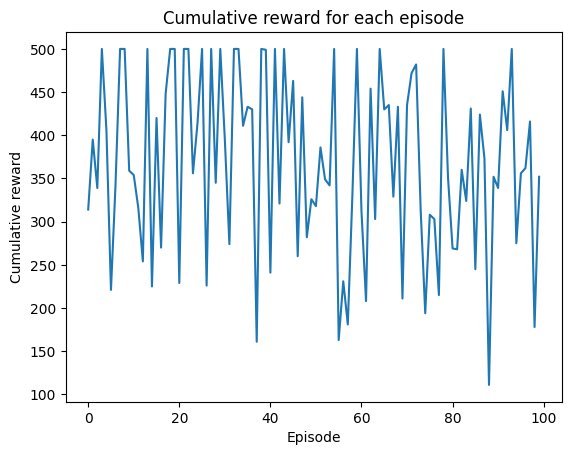

In [ ]:
# summary of last 100 episodes 
task2RewardList = sumRewardsEpisodes[-101:-1]
avg = sum(task2RewardList)/len(task2RewardList)
print("Average cumulative reward:", avg)
print("Is my agent good enough?", avg > 195)

# plots the graph of cumalative reward against all episodes for the last 100 episodes
plt.plot(task2RewardList)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('Episode')
plt.show

With a score of 368.46, we can say that our agent surpasses the criteria of 195 by far. From the graph, we can see there were many times where the agent hits the maximum 500 points ceiling, which is also an indicator of how good the agent performs.

# Task 3: Render one episode played by the agent

We rendered one episode played by the developed RL agent. 
It appears that our RL agent managed to balance the pole for a decent amount of time.

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    action = agentQ(observation, Qmatrix)
    observation, reward, done, info = env.step(action) 
    if done: 
      break;    
env.close()
show_video()

### Thank you for taking the time to review our implementation of a Q-Learning Algorithm for Balancing a Pole on a Cart in the Gym environment!
### We found great enjoyment in analyzing the problem and developing a solution for this assignment. Moving forward, we are excited to continue exploring more advanced reinforcement learning algorithms and to tackle additional problems available in the Gym API.thank-you-placard-concept-illustration_114360-13436.avif